# Zdefiniowanie problemu

# Kamień milowy 2
### Zuzanna Glinka
### Karol Degórski
### Adrian Kamiński

#### Streszczenia artykułów z dziedziny


1.   **[A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)** \
W tym artykule autor pokazuje narzędzie, które pomaga w zrozumieniu przewidywania modelu. Przedstawia moduł SHAP (Shapley Additive exPlanations) oraz metody na bazie których powstał. W artykule umieszczono porównanie ich działania wraz z dowodami i eksperymentami. Metoda SHAP została przedstawiona bezkrytycznie, ciężko dopatrzeć się jej wad przez co zmniejsza wiarygodność artykułu. Główną jej zaletą jest to, że cechuje się zarówno dużą dokładnością jak interpretowalnością.

2.   **[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)**  \
Artykuł wprowadza nową metodę Grad-CAM służącą do wyjaśnień klasyfikacji obrazów dokonywanych przez głębokie sieci neuronowe. Metoda ta jest generalizacją na większą liczbę różnych modeli (np. VGG, VQA) metody CAM, która służy do identyfikacji regionów kluczowych do predykcji danej klasy. Metoda Grad-CAM ma za zadanie zrozumieć znaczenie każdego neuronu do dokonania predykcji. Metoda ta dobrze znajduje kluczowe obszary, co zwiększa interprertowalność, ale niestety precyzja tej metody nie jest satysfakcjonująca (zaznacza ona spore obszary). Aby zwiększyć dokładność autorzy dokonali połączenia Grad-CAM z metodami o wysokiej dokładności tworząc w ten sposób metodę Guided Grad-CAM - wysoka interpretowalność i dokładność.

1. **[Learning a classification model for segmentation](https://ieeexplore.ieee.org/document/1238308)**  \
Artykuł prezentuje model stworzony do klasyfikacji segmentacji jako 'dobrą' lub 'złą'. Korzysta z zasad percepcji Gestalt, contour, texture, brightness i good continuation, na ich podstawie tworzone są featury do modelu regresji logistycznej. Znalezenie dobrej segmentacji było równoważne z maksymalizacją funkcji kryterialnej. Wymaga to jednak przeszukania przestrzeni wszystkich możliwych segmentacji, autorzy artykułu skorzystali z MCMC (Markov Chain Monte Carlo) i zbliżali się do co raz to lepszej segmentacji wykorzystując przesuwanie, dzielenie lub łączenie segmentów. Pomimo tak prostego algorytmu i modelu, do którego została dodana regularyzacja na liczbę segmentów, wyniki nie są najgorsze (model czasami zatrzymuję się na minimum lokalnym).

#### Wstępny działający model do klasyfikacji

Na początku prac nad tym kamieniem milowym wykorzystamy pretrenowany ResNet34

In [1]:
import numpy as np
import os
import math
import random
import warnings
warnings.filterwarnings("ignore")

In [25]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [26]:
import os
CLASSES = os.listdir('./data/train')
CLASSES.sort()
CLASSES = np.array(CLASSES)

In [27]:
_resnet34 = torchvision.models.resnet34(pretrained=True)

In [28]:
class NetWrapper(torch.nn.Module):
    def __init__(self, model, num_classes):
        super(NetWrapper, self).__init__()
        self.model = model
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(1000, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.ReLU = nn.ReLU()
        self.linear = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.linear0(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [29]:
resnet34 = NetWrapper(_resnet34, CLASSES.size).to(device) # CLASSES.size = 4

In [30]:
resnet34.load_state_dict(torch.load('./models_21-04/resnet34.pth', map_location=torch.device(device)))
resnet34.eval()
resnet34.to(device)

NetWrapper(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [46]:
transformations = torchvision.transforms.Compose([
    # torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_set = torchvision.datasets.ImageFolder("data/train/", transform = transformations)
test_set = torchvision.datasets.ImageFolder("data/test/", transform = transformations)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
test_loader = torch.load('test_loader.pt')

#### Wstępne podejście do wyjaśnień

Sprawdzamy, jakie wyjaśnienia proponują nam automatyczne metody tj. Integrated Gradients i Shap

In [31]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [51]:
from skimage import segmentation

def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=100, 
    compactness=0.1, 
    start_label=0,
  )

In [113]:
import torchvision
preprocess = torchvision.transforms.Compose([
   # torchvision.transforms.ToTensor(),
#    torchvision.transforms.Normalize(
#        mean=[0.485, 0.456, 0.406],
#        std=[0.229, 0.224, 0.225]
#    )
])

In [111]:
images, labels = next(iter(train_loader))

In [59]:
from captum.attr import IntegratedGradients
exp_ig = IntegratedGradients(resnet34)

In [60]:
def attr_ig(i):
   return exp_ig.attribute(
       preprocess(images[i].unsqueeze(0)), target=labels[i])

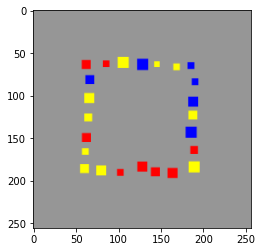

In [129]:
for i in range(1, 10):
    show_attr(attr_ig(i)[0])
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show

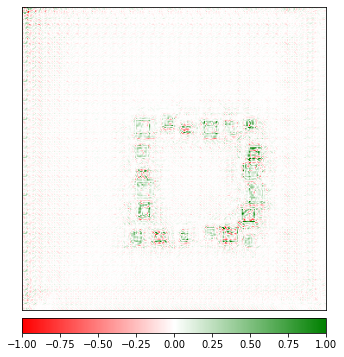

In [61]:
show_attr(attr_ig(3)[0])

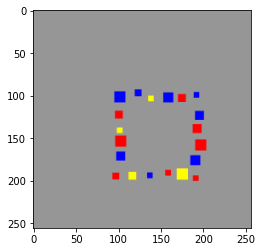

In [90]:
plt.imshow(images[3].permute(1, 2, 0))
plt.show

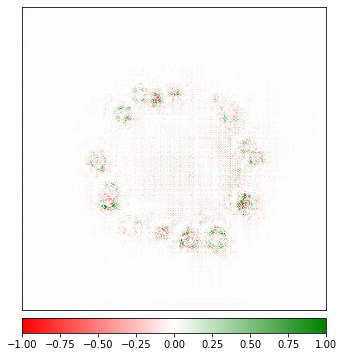

In [75]:
show_attr(attr_ig(4)[0])

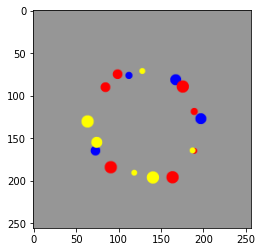

In [85]:
plt.imshow(images[4].permute(1, 2, 0))
plt.show

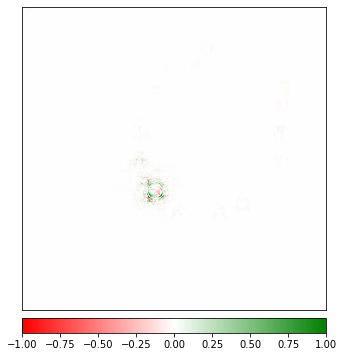

In [76]:
show_attr(attr_ig(5)[0])

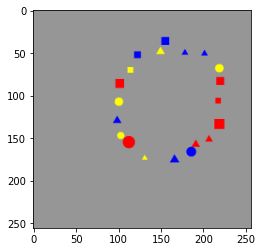

In [95]:
plt.imshow(images[5].permute(1, 2, 0))
plt.show

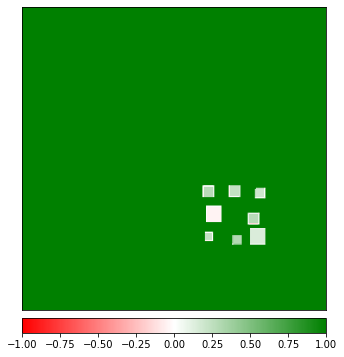

In [151]:
from captum.attr import KernelShap
exp_ks = KernelShap(resnet34)

def mask(i):
    return segmentation.quickshift(
        images[i].permute(1, 2, 0).double(), 
        kernel_size=40, 
        max_dist=7, 
        ratio=0.7
    )


def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(i)),
    show_progress=False
  )

show_attr(attr_ks(10)[0])

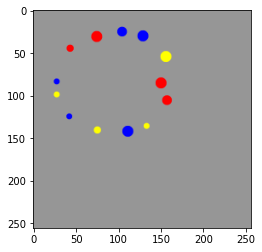

In [155]:
for i in range(1, 5):
    show_attr(attr_ks(i)[0])
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show

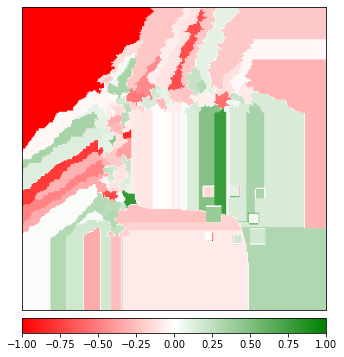

In [156]:
def mask2(i):
    return segmentation.quickshift(
        images[i].permute(1, 2, 0).double(), 
        kernel_size=20, 
        max_dist=5, 
        ratio=0.5
    )


def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask2(i)),
    show_progress=False
  )

show_attr(attr_ks(10)[0])

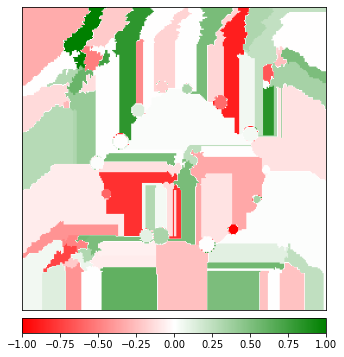

In [167]:
show_attr(attr_ks(3)[0])

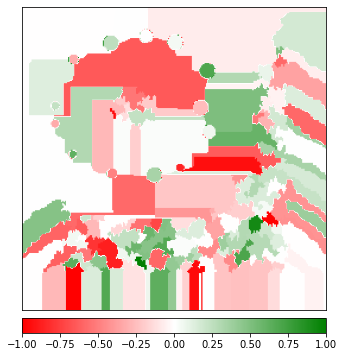

In [168]:
show_attr(attr_ks(4)[0])

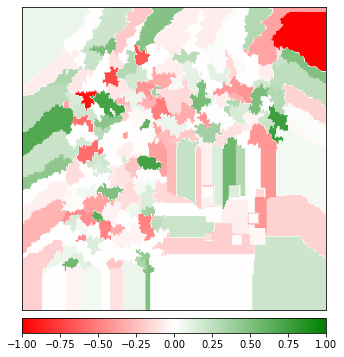

In [161]:
def mask3(i):
    return segmentation.quickshift(
        images[i].permute(1, 2, 0).double(), 
        kernel_size=10, 
        max_dist=7, 
        ratio=0.7
    )


def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask3(i)),
    show_progress=False
  )

show_attr(attr_ks(10)[0])

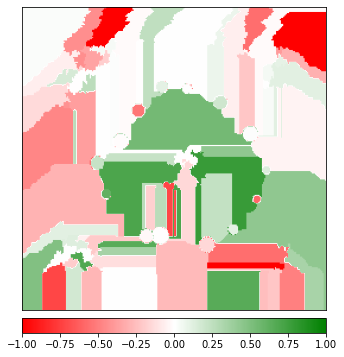

In [165]:
show_attr(attr_ks(3)[0])

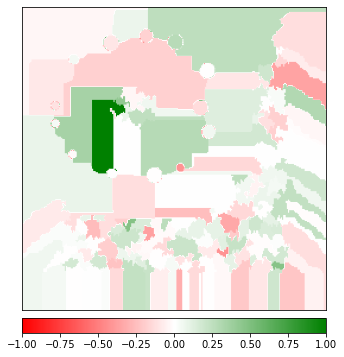

In [166]:
show_attr(attr_ks(4)[0])

Niestety automatyczne metody generacji wyjaśnień nie przyniosły satysfakcjonujących rezultatów (nie mamy dokładnej informacji co przyczyniło się do takiej, a nie innej predykcji). Dlatego też w końcowej fazie projektu skupimy się na nowym podejsciu do wyjaśnień, które poniżej prezentujemy. Podejście to wymagało jednak od nas generacji nowych danych. Zdecydowaliśmy również o rozszerzenie naszego problemu o zachodzące na siebie figury (tak aby model trochę częściej się mylił)

# Tworzenie danych

#### Generowanie nowych danych korzystając z [app-kandinsky-pattern-generator](https://github.com/human-centered-ai-lab/app-kandinsky-pattern-generator)

In [1]:
!pip install inflect

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [2]:
import os

from PIL import Image
from kp import KandinskyUniverse,  KandinskyCaptions, DrawBigSquare, DrawBigCircle, DrawBigTriangle, MultipleFigures
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

u  = KandinskyUniverse.SimpleUniverse()
cg = KandinskyCaptions.CaptionGenerator (u)

def generateClassesAndDetails (basedir, kfgen, n=50,  width=200, true_folder_name='triangle', false_folder_prefix=None, counterfactual = False):
    if false_folder_prefix is None:
        false_folder_prefix = '_' + true_folder_name
    os.makedirs(basedir + "/" + true_folder_name, exist_ok=True)
    os.makedirs(basedir + "/none", exist_ok=True)

    os.makedirs(basedir + "/details/" + true_folder_name, exist_ok=True)
    os.makedirs(basedir + "/details/none", exist_ok=True)
    
    print('Generating true - ', false_folder_prefix)
    for (i, kf) in enumerate(kfgen.true_kf (n)):
        # print(np.array(kf).shape)
        # print(kf)
        if kf is None:
            print(kfgen.true_kf(n))
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + "/" + true_folder_name + "/%06d" % i + ".png")

        cg.figureDetails(kf).to_csv(basedir + "/details/" + true_folder_name + "/%06d" % i + ".csv", index=False)

    print('Generating false - ', false_folder_prefix)
    for (i, kf) in  enumerate(kfgen.false_kf (n // 6)):
        image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
        image.save (basedir + "/none/%06d" % i + false_folder_prefix + ".png")

        
        cg.figureDetails(kf).to_csv(basedir + "/details/none/%06d" % i + false_folder_prefix + ".csv", index=False)

    if (counterfactual):
        os.makedirs(basedir + "/counterfactual", exist_ok=True)
        os.makedirs(basedir + "/details/counterfactual", exist_ok=True)
        for (i, kf) in enumerate(kfgen.almost_true_kf (n)):
            image = KandinskyUniverse.kandinskyFigureAsImage (kf, width)
            image.save (basedir + "/counterfactual/%06d" % i + ".png")
            cg.figureDetails(kf).to_csv(basedir + "/details/counterfactual" + true_folder_name + "/%06d" % i + ".csv", index=False)




Invoking __init__.py for kp


In [71]:
square = MultipleFigures.SingleSquare(u, minList=[2, 6, 4], maxList=[7, 20, 12])
circle = MultipleFigures.SingleCircle(u, minList=[2, 6, 4], maxList=[7, 20, 12])
triangle = MultipleFigures.SingleTriangle(u, minList=[2, 6, 4], maxList=[7, 20, 12])

square_multi1 = MultipleFigures.SquareAndSquareFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
square_multi2 = MultipleFigures.SquareAndCircleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
square_multi3 = MultipleFigures.SquareAndTriangleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])

circle_multi1 = MultipleFigures.CircleAndSquareFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
circle_multi2 = MultipleFigures.CircleAndCircleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
circle_multi3 = MultipleFigures.CircleAndTriangleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])

triangle_multi1 = MultipleFigures.TriangleAndSquareFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
triangle_multi2 = MultipleFigures.TriangleAndCircleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])
triangle_multi3 = MultipleFigures.TriangleAndTriangleFalse(u, minList=[2, 6, 4], maxList=[7, 20, 12])

#### Przykłady używanych przez nas obrazów

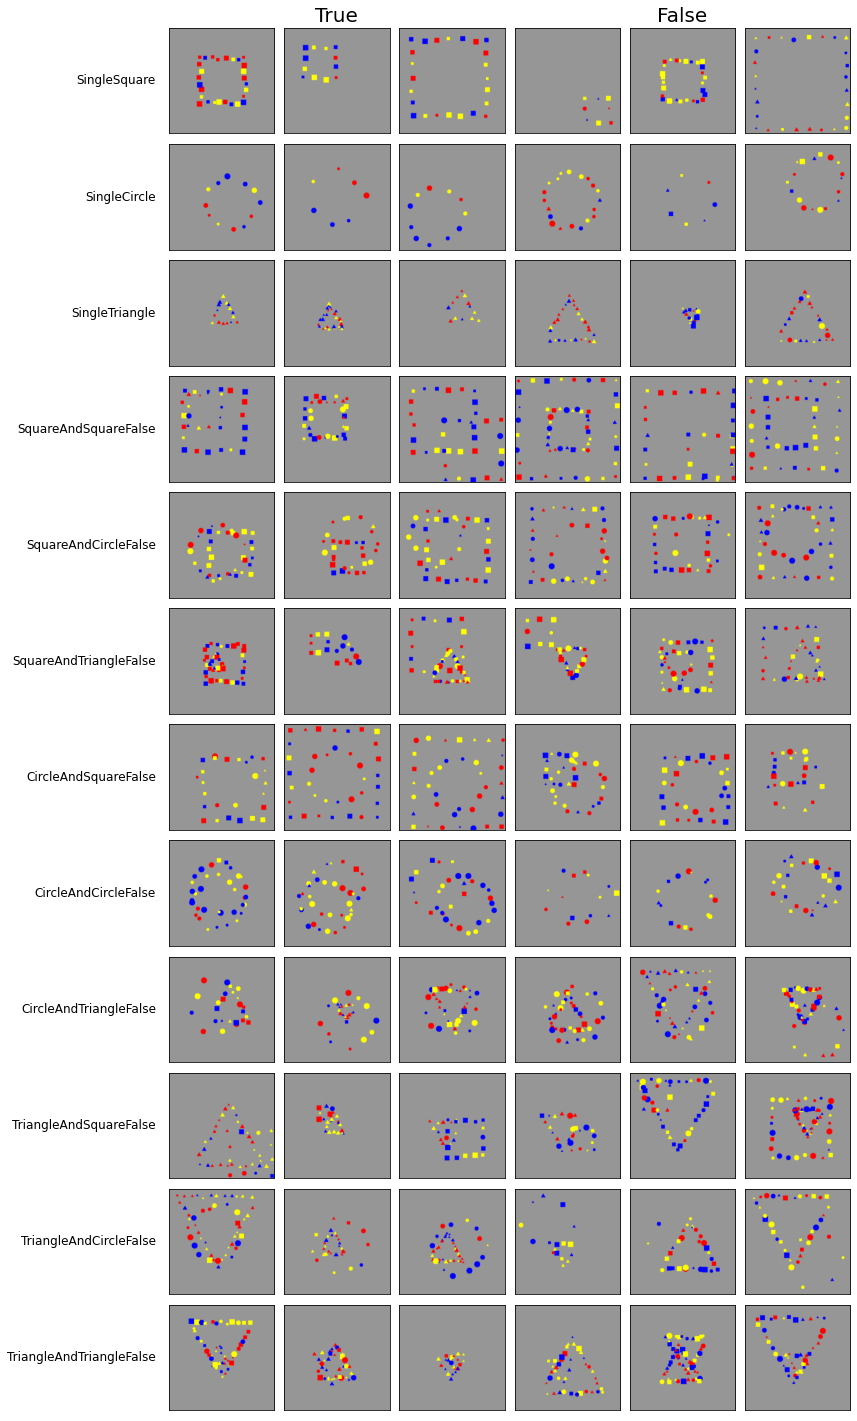

In [72]:
width=256
images = []
kfgens = [
    square, circle, triangle,
    square_multi1, square_multi2, square_multi3,
    circle_multi1, circle_multi2, circle_multi3,
    triangle_multi1, triangle_multi2, triangle_multi3
]
n=3
for kfgen in kfgens:
    for kf in kfgen.true_kf(n):
        images.append(KandinskyUniverse.kandinskyFigureAsImage (kf, width))
    for kf in kfgen.false_kf(n):
        images.append(KandinskyUniverse.kandinskyFigureAsImage (kf, width))

columns = 2*n
rows = 12

fig = plt.figure(figsize=(rows * 4, columns*4))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])

    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    plt.subplots_adjust(left=0.5,
                        bottom=0.1,
                        right=0.7, 
                        top=0.9, 
                        wspace=0.0, 
                        hspace=0.1)
    pad = 5 
    if i == 2:
        plt.title('True', fontdict={'fontsize': 20})
    if i == 5:
        plt.title('False', fontdict={'fontsize': 20})
    if i % 6 == 1:
        plt.annotate(str(kfgens[i//6].__class__).split(".")[-1].split("'")[0],
        xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
plt.show()

#### Wytreniwanie nowego modelu - ResNet18

Zdecydowaliśmy również, o zmianie architektury sieci na prostszą - ResNet18, z uwagi na bardzo wysoką dokładność ResNet34. Dzięki temu oczekujemy, że nasze wyjaśnienia będą bardziej przydatne.

Model trenowaliśmy na Google Colab. Wczytajmy go zatem

In [140]:
import torchvision
_resnet18 = torchvision.models.resnet18(pretrained=True)

In [154]:
resnet18 = NetWrapper(_resnet18, CLASSES.size).to(device)

In [ ]:
resnet18.load_state_dict(torch.load('./models_04-05/resnet18.pth', map_location=torch.device(device)))
resnet18.eval()
resnet18.to(device)

#### Wyniki

Porównanamy wyniki uzyskane przez sieci ResNet34 i EfficentNet trenowane na pierwotnym problemie z wynikami uzyskanymi przez ResNet18 wytrenowany na nowych, trudniejszych danych. 

In [87]:
df1=pd.read_csv('models_04-05/resnet18.csv')
df2=pd.read_csv('models_21-04/results_efficientnet_b0.csv')
df3=pd.read_csv('models_21-04/results_resnet34.csv')

In [141]:

from IPython.display import display_html
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('resnet-18 - advanced problem')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('efficientnet_b0 - simple problem')
df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('resnet34 - simple problem')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_() +df3_styler._repr_html_(), raw=True)

,epoch,loss,accuracy_test,accuracy_train
0,1,0.991478,0.705000,0.890000
1,2,0.947566,0.802500,0.965000
2,3,0.942773,0.770000,0.967500
3,4,0.928264,0.750000,0.965000
4,5,0.932794,0.795000,0.982500
5,6,0.927614,0.817500,0.987500
6,7,0.923924,0.780000,0.992500
7,8,0.929024,0.797500,0.992500
8,9,0.917451,0.785000,0.985000
9,10,0.926721,0.755000,0.975000


Widzimy, że nowy model uzyskał na zbiorze testowym accuracy równe 0.75. Taki poziom accuracy sprawia, że nasze wyjaśnienia będą ciekawsze (pozostałe modele mają accuracy prawie 1)

#### Pomysł na końcowe wyjaśnienia

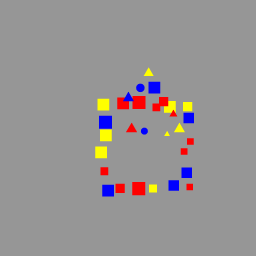

In [166]:
pd.read_csv('data_v3/details/train/square/000001_squareMulti3.csv')

,x,y,shape,size,color,label
0,0.740655,0.729917,square,0.041667,red,true square
1,0.728799,0.674324,square,0.066667,blue,true square
2,0.718930,0.591504,square,0.041667,red,true square
3,0.743088,0.552377,square,0.041667,red,true square
4,0.737199,0.460276,square,0.066667,blue,true square
5,0.677908,0.724392,square,0.066667,blue,true square
6,0.597154,0.736098,square,0.050000,yellow,true square
7,0.541436,0.736385,square,0.083333,red,true square
8,0.468376,0.735140,square,0.058333,red,true square
9,0.422011,0.744095,square,0.075000,blue,true square


Wykorzystanie danych z powyższej tabeli, zawierającej inforamacje o wszystkich kształtach znajdujących się na pojedynczym zdjęciu zapewnia nam możliwość stworzenia globalnych wyjanień. Możemy wyznaczyć na podstawie położenia figur (współrzędne x i y) i miejsc, w których nasze wyjaśnienia się 'podświetlają', które figury wpłyneły na konkretne decyzje (sprawdzić czy w większości przypadków decyduje kształt, kolor, wielkość, a może wyjaśnienia w ogóle nie biorą pod uwagę małych figur). Dowiemy się, zatem czy model dokonując klasyfikacji "myśli" tak jak my.